Here, we briefly introduce how to use the STGCN-Autoencoder for weakly supervised modeling of social behaviors among multiple experimental animals. This section is primarily intended to enable researchers to validate our experimental results. 

🚧Efforts are underway to integrate the STGCN-Autoencoder and other amazing methods for analyzing social behaviors in mice into segTracker.

In the following experiment, there are five mice in the arena, four of which are wild type, and the fifth one is a newcomer. The genotype of this newcomer could be HO (Shank3 -/-), HE (Shank3 -/+), or WT.

We aim to study how this new member interacts with each of the WT (wild type) established members within the group.

> Certainly, you could also analyze all five mice as a single entity. However, this might be overly complex, potentially making the interpretation of the results quite challenging :(

First, install our version of mmaction2 with `cd mmaction2 && pip install -e .` (please refer to mmaction2 doc)

In [1]:
# prepare the dataset: here is how our dataset looks like
'''
{
    'split':{'xub_train':[], 'xub_val':[]},
    'annotations': [{
      'keypoint': np.array[individuals x frames x kpts x 2],
      'label': animal genotype,
      'keypoint_score': np.array[individuals x frames x kpts],
      'total_frames': int,
      'img_shape': (int, int),
      'original_shape': same as img_shape,
      'frame_dir': xsub_train/val name,
      'comb': animal combination (int, int, ...),
      'video_name': int/str,
      'target': index of target animal, could be None if all animals are the same
    }]
}
'''

import pickle
with open('./segCluster_data/2mice_train_val.pkl', 'rb') as f:
    data = pickle.load(f)
data['annotations'][0].keys()

dict_keys(['keypoint', 'label', 'keypoint_score', 'total_frames', 'img_shape', 'original_shape', 'frame_dir', 'comb', 'video_name'])

Then train the model by

1. `cd mmaction2`
2. `python tools/train.py configs/skeleton/stgcnpp/stgcnpp_2mice.py`

Since the weakly-supervised training result may be a little different each time, we will use the pretrained model in this brief tutorial.

> Actually, we find that methods for clustering animal social behaviors are somewhat unstable to varying degrees. Therefore, in our research, we treat the output of the STGCN as an insight, guiding us to understand the potential differences in behavior of these mice on the autism spectrum within a group context.

In [2]:
import numpy as np
import torch

from dataclasses import dataclass
@dataclass
class VideoInfo:
  width: int
  height: int

video_info = VideoInfo(1222, 1072)

def gen_fake_anno(kpts, kpts_scores, h, w):
  fake_anno = dict(
    frame_dir='',
    label=-1,
    img_shape=(h, w),
    original_shape=(h, w),
    start_index=0,
    modality='Pose',
    total_frames=kpts.shape[1])
  fake_anno['keypoint'] = kpts.copy()
  fake_anno['keypoint_score'] = kpts_scores.copy()
  return fake_anno

def extract_feat(model, kpts, score, w, h):
  from mmengine.dataset import Compose, pseudo_collate

  cfg = model.cfg
  test_pipeline_cfg = cfg.test_pipeline
  test_pipeline = Compose(test_pipeline_cfg)

  if isinstance(kpts, list):
    data = []
    for k, s in zip(kpts, score):
      fake_anno = gen_fake_anno(k, s, h, w)
      data.append(test_pipeline(fake_anno))
  else:
    fake_anno = gen_fake_anno(kpts, score, h, w)
    data = [test_pipeline(fake_anno)]
  data = pseudo_collate(data)

  with torch.no_grad():
    processed_data = model.data_preprocessor(data, False)
    res = model(processed_data['inputs'], processed_data['data_samples'], mode='predict')
    feat = [x.feat.item.cpu().numpy() for x in res]
    cls_scores = [x.pred_score.cpu().numpy() for x in res]
  return np.array(feat), np.array(cls_scores)[:, [0, 2, 1]] # make the order to be WT, HE, HO

from mmaction.apis import init_recognizer
model = init_recognizer('./mmaction2/configs/skeleton/stgcnpp/stgcnpp_2mice.py', 'segCluster_data/2mice.pth')

Loads checkpoint by local backend from path: segCluster_data/2mice.pth


In [3]:
# here, we also provide the necessary data for you to reproduce our results
with open('./segCluster_data/features.pkl', 'rb') as f:
    keypoints, keypoint_scores, labels, cls_scores, features = pickle.load(f)

In [4]:
# or you can extract the features by yourself, this might take a while though
feat, score = extract_feat(model, keypoints[0], keypoint_scores[0], video_info.width, video_info.height)

/home/tc/anaconda3/envs/openmmlab/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tc/anaconda3/envs/openmmlab/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tc/anaconda3/envs/openmmlab/lib/python3.9/site-packages/umap/distanc

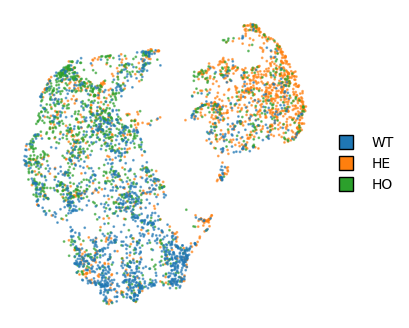

In [5]:
import umap
import umap.plot
import pandas as pd
from utils import plot_tsne

mapper_2d = umap.UMAP(n_neighbors=30, n_components=2, metric='cosine', random_state=1).fit(features)
df = pd.DataFrame(data=mapper_2d.embedding_, columns=['x', 'y'])
df['label'] = labels
df['label'] = df['label'].apply(lambda x: ['WT', 'HE', 'HO'][x])

plot_tsne(mapper_2d.embedding_, df['label'], label_order=['WT', 'HE', 'HO'])

You can use other neural network interpretability tools to analyze the results (see code_to_reproduce_figures.ipynb), or other visualization methods. If preparing the data and other operations seem too complex, we are also working hard to integrate these functionalities into segTracker, so stay tuned :)